In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from nltk.corpus import stopwords
stop = stopwords.words("english")


In [21]:
import nltk
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dkath\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dkath\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import joblib

In [23]:
data = pd.read_csv("sentiment_analysis.csv")

In [24]:
data.head()

,Year,Month,Day,Time of Tweet,text,sentiment,Platform
0,2018,8,18,morning,What a great day!!! Looks like dream.,positive,Twitter
1,2018,8,18,noon,"I feel sorry, I miss you here in the sea beach",positive,Facebook
2,2017,8,18,night,Don't angry me,negative,Facebook
3,2022,6,8,morning,We attend in the class just for listening teac...,negative,Facebook
4,2022,6,8,noon,"Those who want to go, let them go",negative,Instagram


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Year           499 non-null    int64 
 1   Month          499 non-null    int64 
 2   Day            499 non-null    int64 
 3   Time of Tweet  499 non-null    object
 4   text           499 non-null    object
 5   sentiment      499 non-null    object
 6   Platform       499 non-null    object
dtypes: int64(3), object(4)
memory usage: 27.4+ KB


In [26]:
data.describe()

,Year,Month,Day
count,499.000000,499.000000,499.000000
mean,2020.394790,6.084168,15.693387
std,2.830991,3.652711,8.804673
min,2010.000000,1.000000,1.000000
25%,2019.000000,2.000000,8.000000
50%,2021.000000,6.000000,15.000000
75%,2023.000000,9.000000,22.000000
max,2023.000000,12.000000,31.000000


In [27]:
data["sentiment"].value_counts()

sentiment
neutral     199
positive    166
negative    134
Name: count, dtype: int64

In [28]:
def basic_cleaning(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

data["cleaned_text"] = data["text"].apply(basic_cleaning)

In [29]:
data[["text", "cleaned_text", "sentiment"]].head(10)

,text,cleaned_text,sentiment
0,What a great day!!! Looks like dream.,what a great day looks like dream,positive
1,"I feel sorry, I miss you here in the sea beach",i feel sorry i miss you here in the sea beach,positive
2,Don't angry me,dont angry me,negative
3,We attend in the class just for listening teac...,we attend in the class just for listening teac...,negative
4,"Those who want to go, let them go",those who want to go let them go,negative
5,"Its night 2 am, feeling neutral",its night 2 am feeling neutral,neutral
6,2 am feedings for the baby are fun when he is ...,2 am feedings for the baby are fun when he is ...,positive
7,Soooo high,soooo high,neutral
8,Both of you,both of you,neutral
9,Today first time I arrive in the boat. Its ama...,today first time i arrive in the boat its amaz...,positive


In [30]:
X = data["cleaned_text"].values
y_raw = data["sentiment"].values

In [31]:
le = LabelEncoder()
y = le.fit_transform(y_raw)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [33]:
print("Train Size: ", len(X_train))
print("Test Size: ", len(X_test))
print("Classes: ", len(le.classes_))

Train Size:  399
Test Size:  100
Classes:  3


In [44]:
pipeline = Pipeline([
    ("vectorizer", CountVectorizer()),
    ("catboost", CatBoostClassifier(
        verbose=False,      
        random_state=42
    ))
])

In [45]:
param_distributions = {
    # Vectorizer hyperparameters
    "vectorizer__stop_words": ["english", None],       
    "vectorizer__max_features": [3000, 5000, 10000],   
    "vectorizer__ngram_range": [(1,1), (1,2)],         
    "vectorizer__max_df": [0.5, 0.75, 1.0],            
    
    # CatBoost hyperparameters
    "catboost__iterations": [200, 300, 500],
    "catboost__depth": [4, 6, 8],
    "catboost__learning_rate": [0.01, 0.05, 0.1, 0.2],
    "catboost__l2_leaf_reg": [1, 3, 5, 7],
}

In [47]:
from sklearn.model_selection import RandomizedSearchCV

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=20,            
    scoring="accuracy",
    cv=3,                  
    verbose=2,
    random_state=42,
    n_jobs=-1             
)

print("Starting RandomizedSearchCV ...")
search.fit(X_train, y_train)

print("\nDone. Best params found:")
print(search.best_params_)


Starting RandomizedSearchCV ...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Done. Best params found:
{'vectorizer__stop_words': None, 'vectorizer__ngram_range': (1, 1), 'vectorizer__max_features': 10000, 'vectorizer__max_df': 0.75, 'catboost__learning_rate': 0.2, 'catboost__l2_leaf_reg': 1, 'catboost__iterations': 300, 'catboost__depth': 6}


In [49]:
print(f"Best CV accuracy: {search.best_score_:.4f}")

Best CV accuracy: 0.6391


In [50]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

In [55]:
base_model = search.best_estimator_

y_pred = base_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="weighted")
rec = recall_score(y_test, y_pred, average="weighted")
f1 = f1_score(y_test, y_pred, average="weighted")

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"f1: {f1:.4f}")
print("\nClassification Report:")
print(classification_report(
    y_test,
    y_pred,
    target_names=le.classes_
))


Accuracy: 0.7200
Precision: 0.7588
Recall: 0.7200
f1: 0.7106

Classification Report:
              precision    recall  f1-score   support

    negative       0.80      0.44      0.57        27
     neutral       0.63      0.93      0.75        40
    positive       0.88      0.70      0.78        33

    accuracy                           0.72       100
   macro avg       0.77      0.69      0.70       100
weighted avg       0.76      0.72      0.71       100



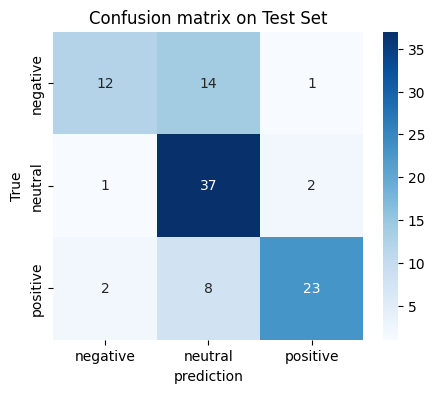

In [56]:
import seaborn as sns
cf_matrix= confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion matrix on Test Set")
plt.xlabel("prediction")
plt.ylabel("True")
plt.show()

In [57]:
joblib.dump(base_model, "catboost_text_classifier.pkl")
joblib.dump(le, "label_encoder.pkl")

['label_encoder.pkl']

In [58]:
loaded_model = joblib.load("catboost_text_classifier.pkl")

text = ["I am so happy today!"]
y_new = loaded_model.predict(text)
print(y_new)

[[2]]


In [59]:
loaded_model = joblib.load("catboost_text_classifier.pkl")
le_loaded = joblib.load("label_encoder.pkl")

text = ["I am so happy today!"]
y_new = loaded_model.predict(text)

sentiment = le_loaded.inverse_transform(y_new)
print(sentiment)

['positive']


c:\Users\dkath\anaconda3\envs\StackWalls\lib\site-packages\sklearn\preprocessing\_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [61]:
import requests

url = "http://127.0.0.1:8000/predict"
data = {"text": "I am so happy today!"}

response = requests.post(url, json=data)
print(response.json())


{'input_text': 'I am so happy today!', 'predicted_sentiment': 'positive'}
